# Test Models

This notebook tests deep learning models for enhanced JPEG reconstruction.

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys

from tensorflow.spectral import dct, idct
from scipy.fftpack import dct as DCT, idct as IDCT
from tensorflow.keras.backend import eval

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from models import unet_old, unet, my_unet

Using TensorFlow backend.


In [2]:
# Train and validation data paths
test_path = "/home/ubuntu/volume1/TIFF/Testing/*.tif"

# Listing train and validation images
test_images = glob.glob(test_path)

# Summary of images
print("Test set size:", len(test_images))

Test set size: 16110


In [3]:
H,W = 256, 256
norm = 255.0
compr_range = (10,20)

test_unc = np.zeros((len(test_images),H,W,1), dtype=np.float32)
test_compr = test_unc.copy()

dct_test_unc = test_unc.copy()
dct_test_compr = test_unc.copy()

compr_test = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(test_images),replace = True)

# Test set
for ii in range(len(test_images)):
    # Load uncompressed image
    im1 = Image.open(test_images[ii])
    test_unc[ii,:,:,0] = np.array(im1)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_test[ii]))
    im2 = Image.open(buf)
    test_compr[ii,:,:,0] = np.array(im2)

test_unc /= norm
test_compr /= norm

for ii in range(len(test_images)):
    dct_test_unc[ii,:,:,0] = DCT(test_unc[ii,:,:,0])
    dct_test_compr[ii,:,:,0] = DCT(test_compr[ii,:,:,0])
    
# dct_test_unc = (dct_test_unc - np.min(dct_test_unc)) / (np.max(dct_test_unc) - np.min(dct_test_unc))
# dct_test_compr = (dct_test_compr - np.min(dct_test_compr)) / (np.max(dct_test_compr) - np.min(dct_test_compr))

In [37]:
# # keep min/max values to de-normalize later
# dct_test_compr_min = np.zeros(len(test_images))
# dct_test_compr_max = np.zeros(len(test_images))

# for ii in range(len(test_images)):
#     dct_test_compr_min[ii] = np.min(dct_test_compr[ii,:,:,0])
#     dct_test_compr_max[ii] = np.max(dct_test_compr[ii,:,:,0])

# print(dct_test_compr_min.shape)
# print(dct_test_compr_max.shape)

(16110,)
(16110,)


In [41]:
# # normalize

# #print(dct_test_compr[11])
# for ii in range(len(test_images)):
#     dct_test_compr[ii,:,:,0] = (dct_test_compr[ii,:,:,0] - dct_test_compr_min[ii]) / \
#     (dct_test_compr_max[ii] - dct_test_compr_min[ii])

[[[0.38276207]
  [0.3827609 ]
  [0.3827609 ]
  ...
  [0.3827609 ]
  [0.3827609 ]
  [0.3827609 ]]

 [[0.38276207]
  [0.3827609 ]
  [0.3827609 ]
  ...
  [0.3827609 ]
  [0.3827609 ]
  [0.3827609 ]]

 [[0.38276207]
  [0.3827609 ]
  [0.3827609 ]
  ...
  [0.3827609 ]
  [0.3827609 ]
  [0.3827609 ]]

 ...

 [[0.38276207]
  [0.3827609 ]
  [0.3827609 ]
  ...
  [0.3827609 ]
  [0.3827609 ]
  [0.3827609 ]]

 [[0.38276207]
  [0.3827609 ]
  [0.3827609 ]
  ...
  [0.3827609 ]
  [0.3827609 ]
  [0.3827609 ]]

 [[0.38276207]
  [0.3827609 ]
  [0.3827609 ]
  ...
  [0.3827609 ]
  [0.3827609 ]
  [0.3827609 ]]]


In [4]:
opt=Adam(lr=0.0001)
model_name = "../Models/residual_unet_DCT_data_augmentation_compress_10_20-2.hdf5"
#model = unet_old(input_size = (256 ,256 ,1),drop = 0.0,residual = True)
model=my_unet()
model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)

In [30]:
pred = model.predict(dct_test_compr)

In [31]:
img_pred = test_unc.copy()

for ii in range(len(test_images)):
    #dct_pred_arr[ii,:,:,0] = eval(pred[ii,:,:,0])
#     img_pred[ii,:,:,0] = IDCT(pred[ii,:,:,0]*(dct_test_compr_max[ii] - dct_test_compr_min[ii]) \
#     + dct_test_compr_min[ii])
    img_pred[ii,:,:,0] = IDCT(pred[ii,:,:,0])
    # Normalize image to 0, 1
    img_pred[ii,:,:,0] = (img_pred[ii,:,:,0] - np.min(img_pred[ii,:,:,0])) / \
    (np.max(img_pred[ii,:,:,0]) - np.min(img_pred[ii,:,:,0]))

0.0 0.72156864
0.0 1.0


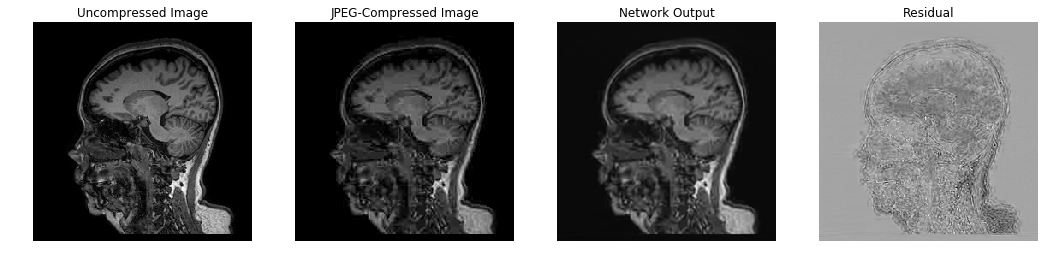

In [32]:
#print(pred)

slc = 63

print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(img_pred[slc,:,:,0]),np.max(img_pred[slc,:,:,0]))

# plt.figure(figsize = (9,18))
# plt.subplot(3,1,1)
# plt.axis("off")
# plt.title("Uncompressed Image", fontsize=24)
# plt.imshow(dct_test_unc[slc,:,:,0],cmap = "gray")
# plt.subplot(3,1,2)
# plt.axis("off")
# plt.title("Network Output", fontsize=24)
# plt.imshow(pred[slc,:,:,0],cmap = "gray")
# plt.subplot(3,1,3)
# plt.axis("off")
# plt.title("Residual", fontsize=24)
# plt.imshow((dct_test_unc[slc,:,:,0] - img_pred[slc,:,:,0]),cmap = "gray")
# plt.show()

plt.figure(figsize = (18,12))
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Network Output")
plt.imshow(img_pred[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow((test_unc[slc,:,:,0] - img_pred[slc,:,:,0]),cmap = "gray")
plt.show()

Test set results
0.0 0.9019608
0.0 1.0
0.0 0.7254902
0.0 1.0
0.0 0.5294118
0.0 1.0


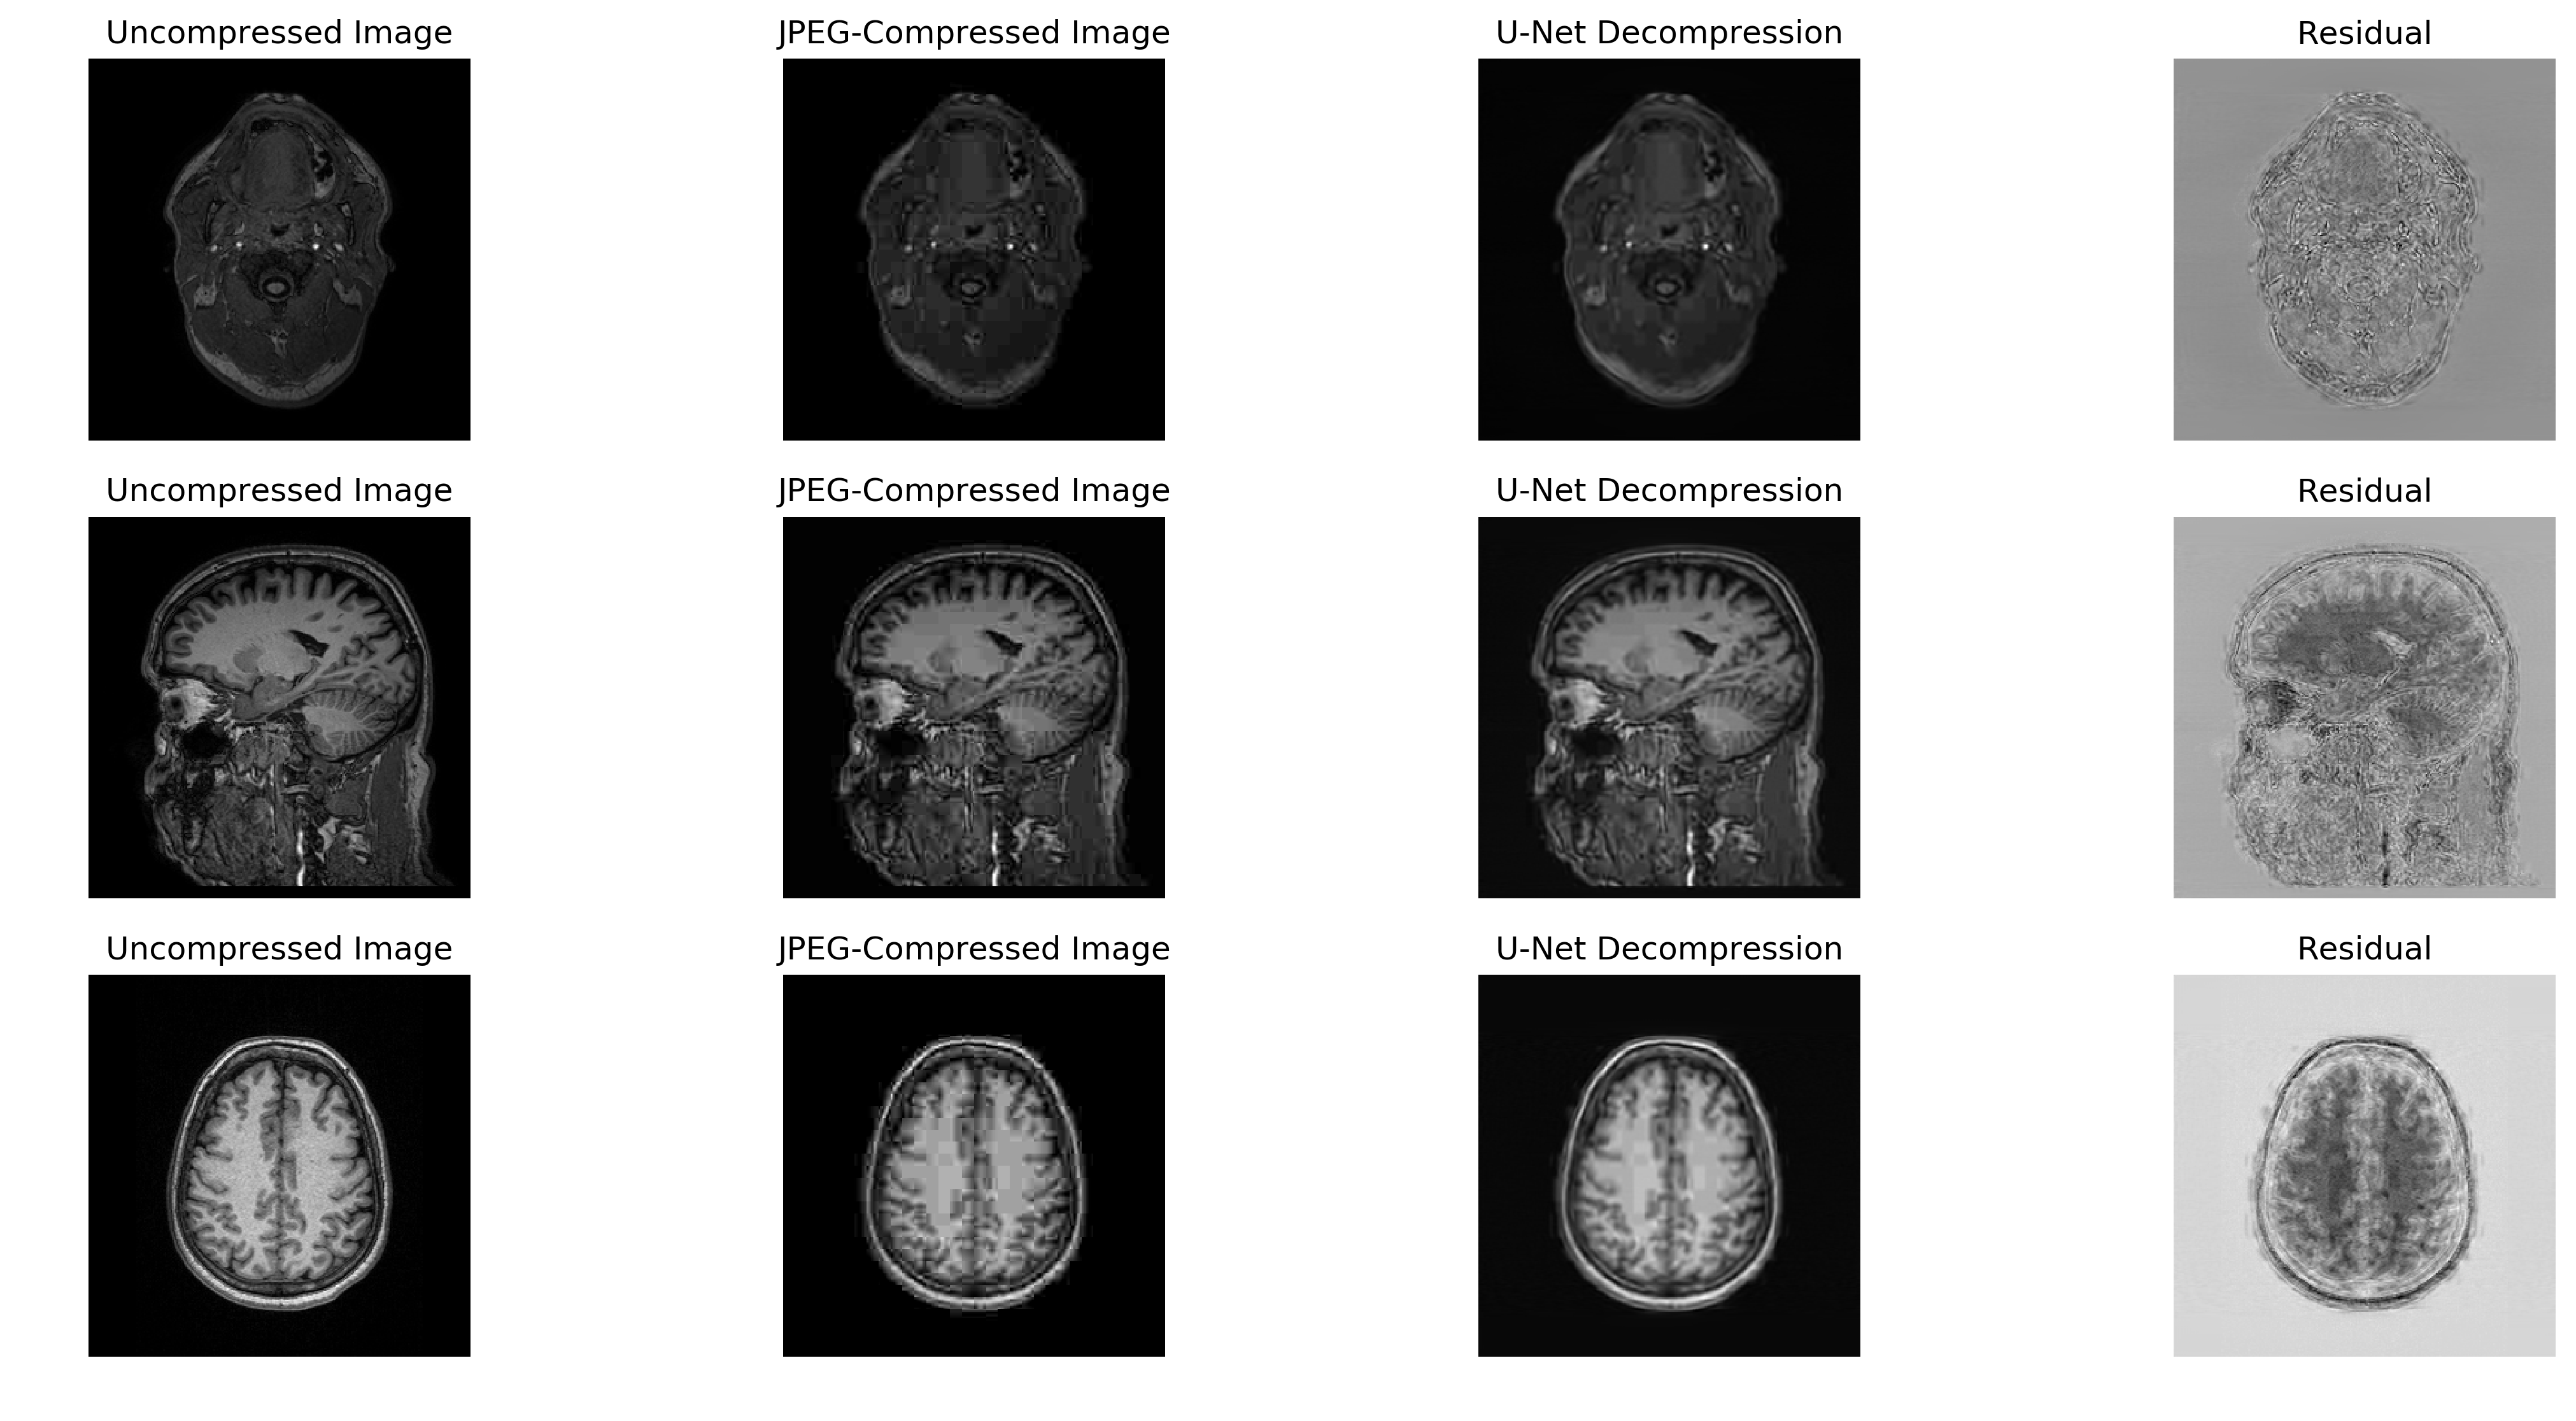

In [36]:
indexes_test = np.arange(len(test_images),dtype = int)
np.random.shuffle(indexes_test)
indexes_test = indexes_test[:3]

print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    print(np.min(test_unc[indexes_test[ii],:,:,0]),np.max(test_unc[indexes_test[ii],:,:,0]))
    print(np.min(img_pred[indexes_test[ii],:,:,0]),np.max(img_pred[indexes_test[ii],:,:,0]))

    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Image")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Image")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(img_pred[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("U-Net Decompression")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(test_unc[indexes_test[ii],:,:,0] - img_pred[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

In [ ]:
import skimage.measure as metrics

In [ ]:
# SSIM

plt.figure(dpi = 300)
plt.errorbar(range(1,100), ssim[0,:], ssim[1,:],linestyle='None', marker='^')
plt.xlabel("Quality Factor")
plt.ylabel("Mean SSIM (std)")
plt.grid()
plt.show()

In [ ]:
# PSNR
plt.figure(dpi = 300)
plt.errorbar(range(1,100), psnr[1,:], psnr[2,:],linestyle='None', marker='^')
plt.xlabel("Quality Factor")
plt.ylabel("Mean PSNR (std)")
plt.grid()
plt.show()

In [ ]:
# NRMSE
plt.figure(dpi = 300)
plt.errorbar(range(1,100), nrmse[1,:], nrmse[2,:],linestyle='None', marker='^')
plt.xlabel("Quality Factor")
plt.ylabel("Mean NRMSE (std)")
plt.grid()
plt.show()